# **Assignment: SemEval 2025 Task 9 - Food Hazard Detection Challenge**

This assignment tasks us with participating in the **SemEval 2025 Task 9: The Food Hazard Detection Challenge**. The goal is to explore and classify food hazard incidents based on text data, by predicting the category of hazard and product and also the actual hazard and product type. We will work with both short texts (titles) and long texts (full descriptions) provided in the dataset, performing benchmark analyses using basic and advanced machine learning algorithms.

By the end of the assignment, we will compare the results from these models, determine which approach performs best, and prepare our predictions for submission. The final submission will include the prediction results, along with the models used, evaluation metrics, and our ranking on the competition leaderboard.

In [2]:
# Import Necessary Libraries
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns, os, re, numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

import evaluate
import torch
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import Dataset

import warnings
warnings.filterwarnings("ignore")

/opt/anaconda3/envs/Omni/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
0it [00:00, ?it/s]
2024-11-28 23:42:40.281850: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Exploration and Preprocessing

In this step, we will load and explore the provided dataset to understand its structure. We will check for any missing data, imbalances in the labels, and perform basic data cleaning tasks. 

### Loading the Dataset

Loading the data directly from GitHub with 

`pd.read_csv('https://github.com/food-hazard-detection-semeval-2025/food-hazard-detection-semeval-2025.github.io/blob/main/data/incidents_train.csv')`

throws an error. Also `!wget` will download the file but we won't be able to read it.

So we have to manually download it and save it to our directory.

In [ ]:
# Path to our working directory
wrk_directory_path = '/'.join(os.getcwd().split("/")[:-1])  # Path of the parent directory of this notebook 

# Load the dataset
train_data = pd.read_csv(wrk_directory_path + '/Data/incidents_train.csv')

# Preview the first few rows of the data
train_data.head()

,Unnamed: 0,year,month,day,country,title,text,hazard-category,product-category,hazard,product
0,0,1994,1,7,us,Recall Notification: FSIS-024-94,Case Number: 024-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,smoked sausage
1,1,1994,3,10,us,Recall Notification: FSIS-033-94,Case Number: 033-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria spp,sausage
2,2,1994,3,28,us,Recall Notification: FSIS-014-94,Case Number: 014-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,ham slices
3,3,1994,4,3,us,Recall Notification: FSIS-009-94,Case Number: 009-94 \n Date Opene...,foreign bodies,"meat, egg and dairy products",plastic fragment,thermal processed pork meat
4,4,1994,7,1,us,Recall Notification: FSIS-001-94,Case Number: 001-94 \n Date Opene...,foreign bodies,"meat, egg and dairy products",plastic fragment,chicken breast


In [6]:
# Drop the "Unnamed: 0" column
train_data = train_data.drop(columns=['Unnamed: 0'])

### Check Dataframe Information and Data Types

Let’s inspect the structure of the dataset by checking the data types of each column and ensuring that the dataset is correct. This will help us spot any inconsistencies or issues before proceeding with preprocessing.


In [4]:
# Check the dataframe information and data types
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5082 entries, 0 to 5081
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   year              5082 non-null   int64 
 1   month             5082 non-null   int64 
 2   day               5082 non-null   int64 
 3   country           5082 non-null   object
 4   title             5082 non-null   object
 5   text              5082 non-null   object
 6   hazard-category   5082 non-null   object
 7   product-category  5082 non-null   object
 8   hazard            5082 non-null   object
 9   product           5082 non-null   object
dtypes: int64(3), object(7)
memory usage: 397.2+ KB


### Checking for Missing Data

We need to ensure that there are no missing values in the dataset.

In [5]:
train_data.isnull().sum()

year                0
month               0
day                 0
country             0
title               0
text                0
hazard-category     0
product-category    0
hazard              0
product             0
dtype: int64

### Visualizing Label Distribution

Let's visualize the class distribution for both `product-category` and `hazard-category` labels.

/var/folders/7m/tn2lww617kl3zw0vkb4p06q80000gp/T/ipykernel_50476/1183134477.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='product-category', data=train_data, order=train_data['product-category'].value_counts().index, palette='viridis')


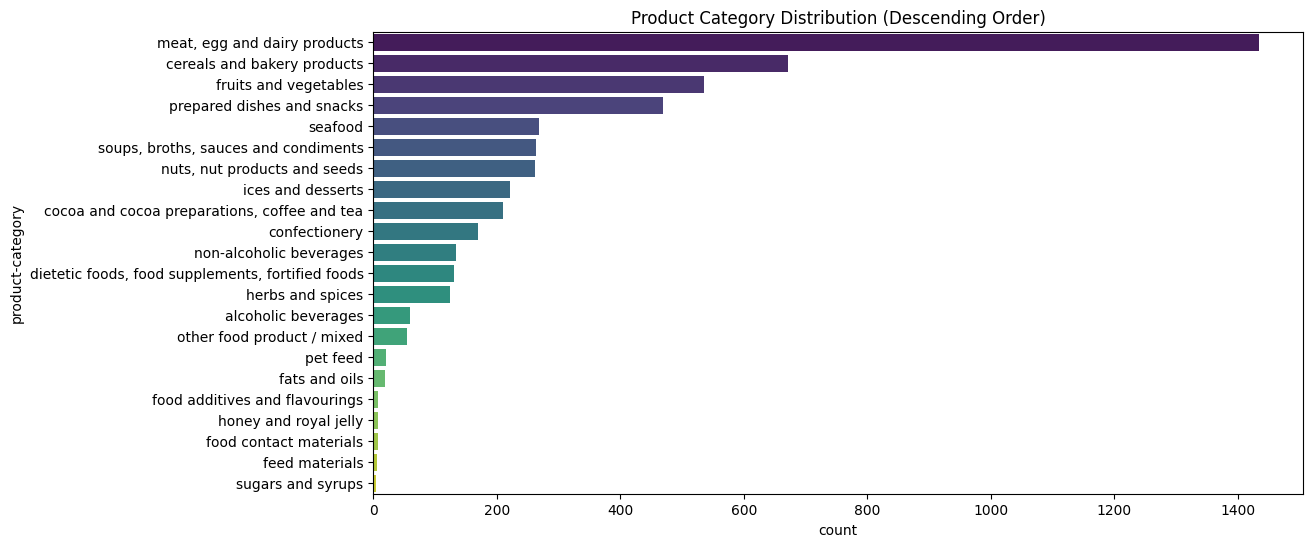

/var/folders/7m/tn2lww617kl3zw0vkb4p06q80000gp/T/ipykernel_50476/1183134477.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='hazard-category', data=train_data, order=train_data['hazard-category'].value_counts().index, palette='viridis')


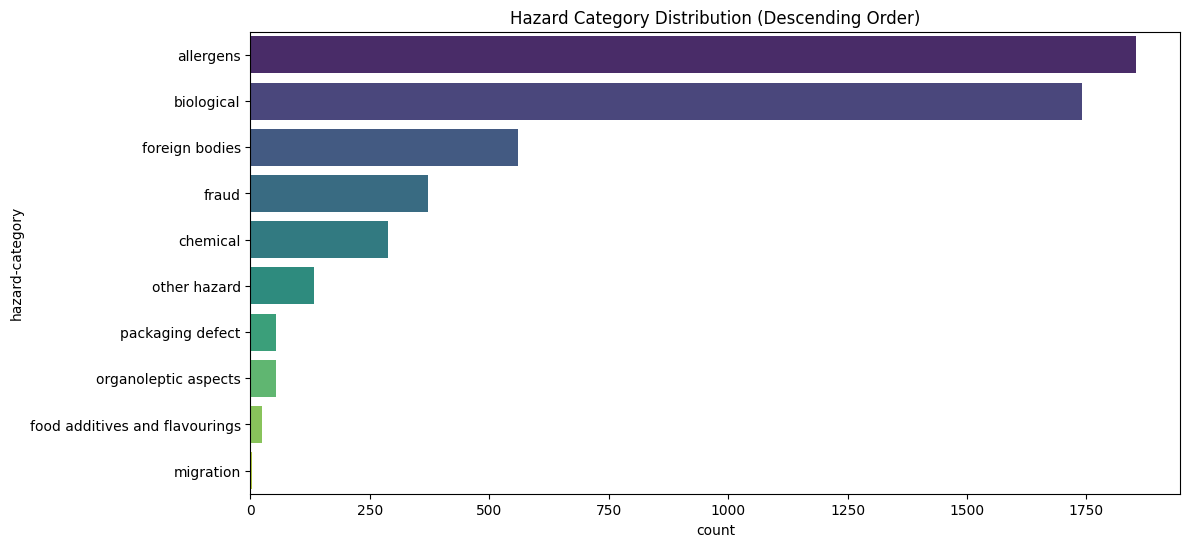

In [6]:
# Visualizing class distribution for 'product-category' and 'hazard-category' in descending order
plt.figure(figsize=(12, 6))
sns.countplot(y='product-category', data=train_data, order=train_data['product-category'].value_counts().index, palette='viridis')
plt.title('Product Category Distribution (Descending Order)')
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(y='hazard-category', data=train_data, order=train_data['hazard-category'].value_counts().index, palette='viridis')
plt.title('Hazard Category Distribution (Descending Order)')
plt.show()


### **Product Category Distribution Analysis**

The `product-category` column shows a clear class imbalance, with some categories being significantly more frequent than others.

- **High Frequency Categories**: 
    - "meat, egg and dairy products" (1434 occurrences) is the most frequent category by far.
    - Other relatively frequent categories include "cereals and bakery products" (671), "fruits and vegetables" (535), and "prepared dishes and snacks" (469).

- **Medium Frequency Categories**:
    - Categories like "seafood" (268), "soups, broths, sauces and condiments" (264), and "nuts, nut products and seeds" (262) are still moderately frequent but represent a smaller portion of the dataset.

- **Low Frequency Categories**:
    - Categories such as "pet feed" (20), "fats and oils" (19), and "food additives and flavourings" (8) are much less frequent, with only a few occurrences.

- **Rare Categories**:
    - A few categories like "feed materials" (6), "sugars and syrups" (5), and "food contact materials" (7) are extremely rare, making them challenging to predict accurately.

#### **Impact on Model Training**:
The highly imbalanced distribution of product categories suggests that the data are biased towards the majority classes (e.g., "meat, egg and dairy products") because they dominate the dataset. This is an important consideration when training the model, as it may lead to poorer performance for the minority classes.

#### **Recommended Split Strategy**:

- **Stratified Split (80% Training, 20% Testing)**:

    Stratified split is essential to ensure that even the rare classes are represented in both the training and test sets. 
    Without stratification, some rare classes might be left out of the test set entirely, which would make it difficult to evaluate model performance on these important but underrepresented classes.

- Why Not Random Split?

    A random split could result in empty test sets for rare classes or poor representation of small classes in the test set, which would make our evaluation metrics unreliable, particularly for the rare classes.
    With such a severe imbalance, random splitting might lead to situations where your test set ends up missing rare classes completely.

### **Hazard Category Distribution Analysis**

The `hazard-category` column also shows a skewed distribution, with some categories being far more frequent than others.

- **High Frequency Categories**:
    - "allergens" (1854 occurrences) is the most frequent hazard category.
    - "biological" (1741 occurrences) also represents a large portion of the dataset, closely following allergens in terms of frequency.

- **Medium Frequency Categories**:
    - Categories like "foreign bodies" (561), "fraud" (371), and "chemical" (287) are still reasonably frequent but represent a smaller proportion of the dataset.

- **Low Frequency Categories**:
    - "other hazard" (134), "packaging defect" (54), and "organoleptic aspects" (53) are relatively rare but still appear in the dataset.

- **Very Rare Categories**:
    - "food additives and flavourings" (24) and "migration" (3) are extremely rare hazards, with "migration" having the least occurrences.

#### **Impact on Model Training**:
The hazard categories also exhibit a significant imbalance. Much like the `product-category`, the data is likely to be biased towards the majority classes, especially **"allergens"** and **"biological"**.

#### **Recommended Split Strategy**:

- **Stratified Split (80% Training, 20% Testing)**:
  
    Stratified split is crucial here because we want to ensure that each class, including the very rare ones like Migration, Food Additives, and Organoleptic Aspects, is sufficiently represented in both the training and test sets.

- Why not Random Split?
   
    A random split might result in some classes (especially the very rare ones) being left out of the training or test set entirely due to their low frequency.
    This would lead to poor generalization, especially when deploying models trained on this dataset in real-world scenarios.

### **Visualizing the Distribution of Year, Hazard, Product, and Country Columns**

Let's plot the distribution for the following columns:
1. **Year**: To understand how the recalls are spread across different years.
2. **Hazard**: To visualize the distribution of specific hazards involved in the recalls.
3. **Product**: To see the frequency of different products involved in recalls.
4. **Country**: To examine how the recalls are distributed across different countries.

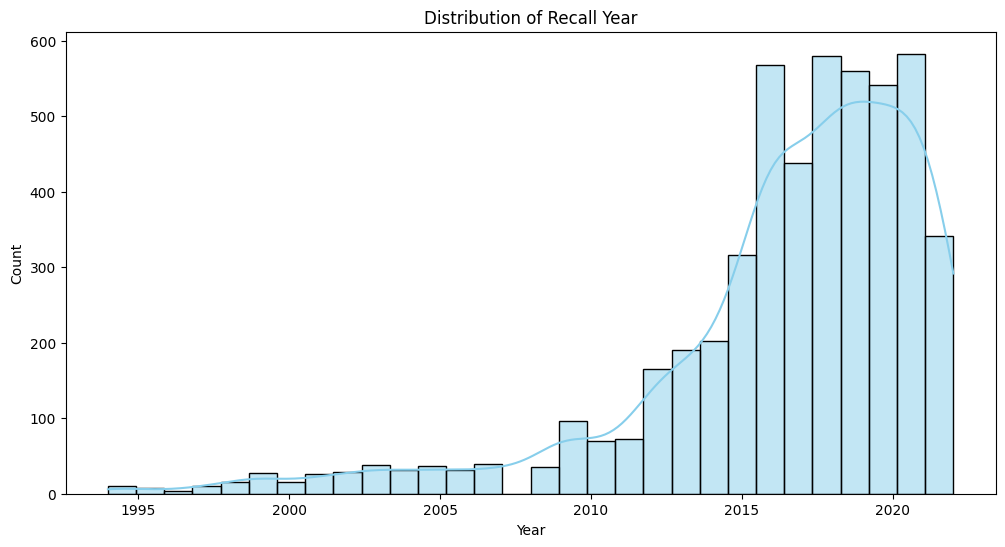

/var/folders/7m/tn2lww617kl3zw0vkb4p06q80000gp/T/ipykernel_50476/1890362455.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='country', data=train_data, order=train_data['country'].value_counts().index, palette='viridis')


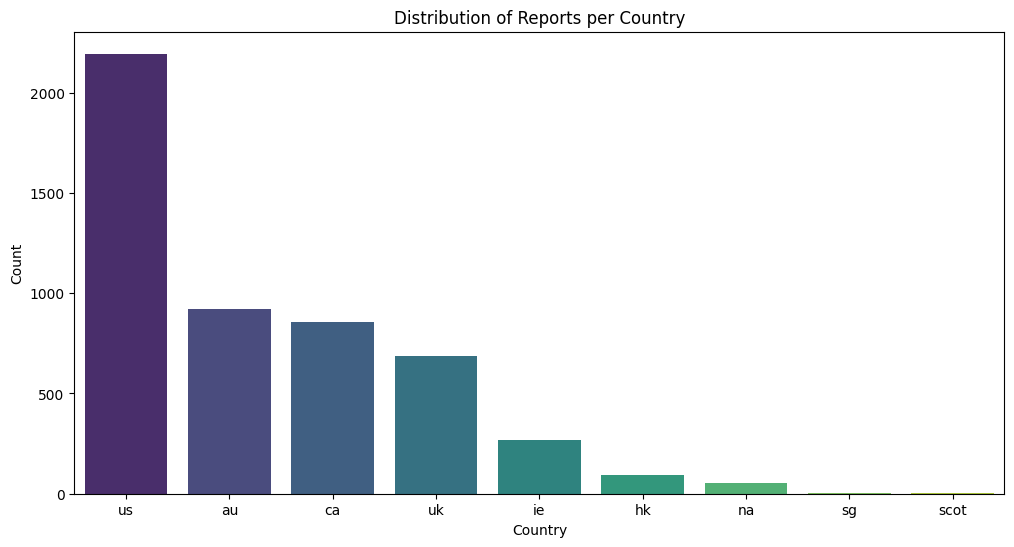

/var/folders/7m/tn2lww617kl3zw0vkb4p06q80000gp/T/ipykernel_50476/1890362455.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='hazard', data=train_data, order=train_data['hazard'].value_counts().index[:20], palette='viridis')  # Show top 20 hazards


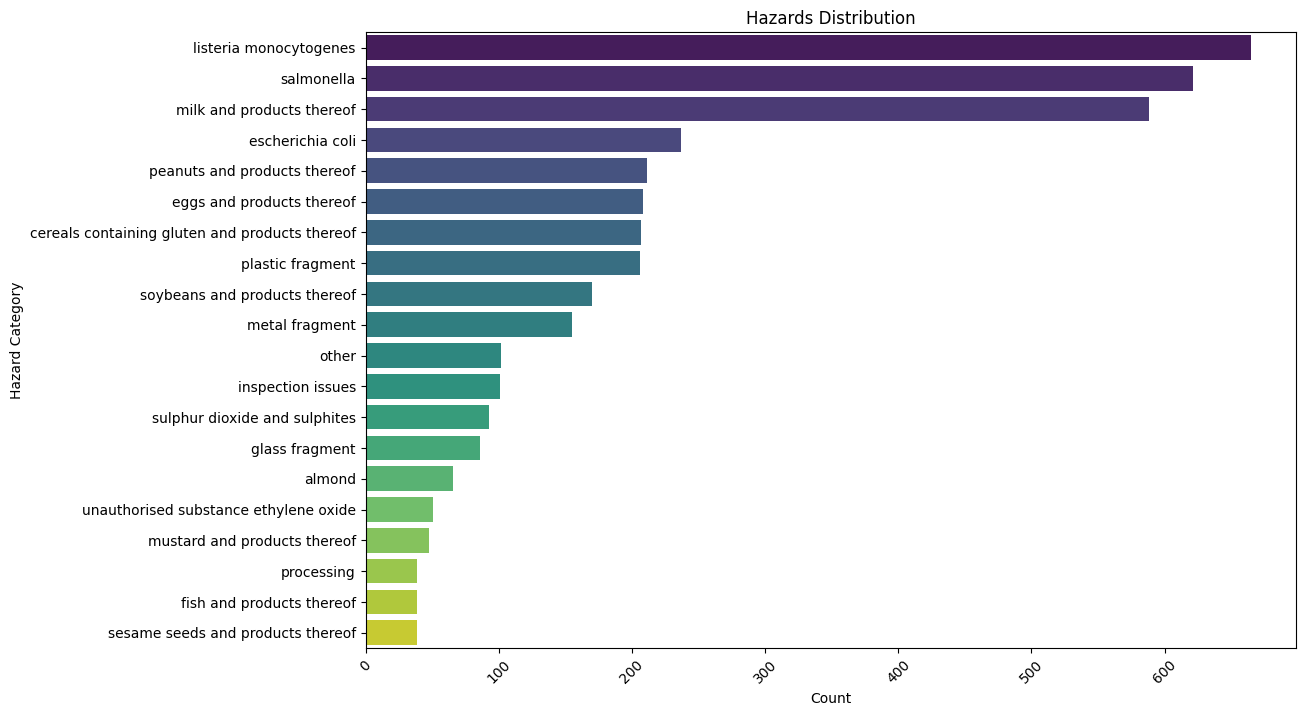

/var/folders/7m/tn2lww617kl3zw0vkb4p06q80000gp/T/ipykernel_50476/1890362455.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='product', data=train_data, order=train_data['product'].value_counts().index[:20], palette='viridis')  # Show top 20 products


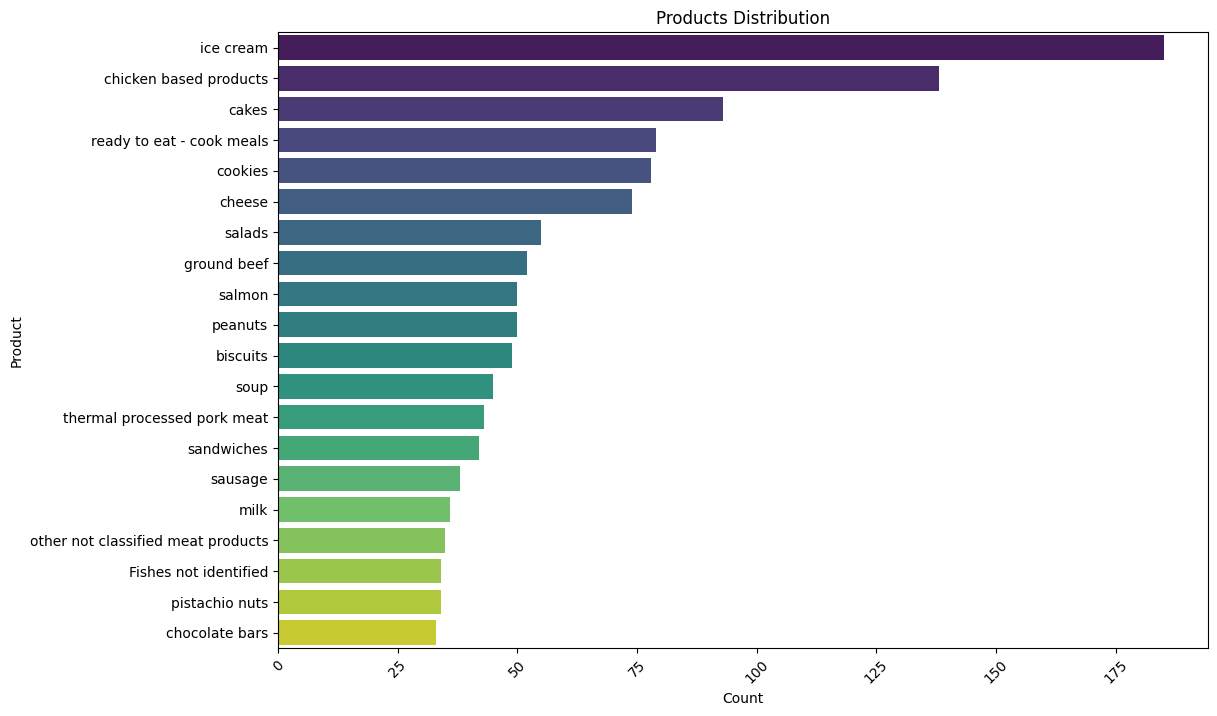

In [7]:
# Plotting the distribution of 'year'
plt.figure(figsize=(12, 6))
sns.histplot(train_data['year'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Recall Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

# Plotting the distribution of 'country' values
plt.figure(figsize=(12, 6))
sns.countplot(x='country', data=train_data, order=train_data['country'].value_counts().index, palette='viridis')
plt.title('Distribution of Reports per Country')
plt.xlabel('Country')
plt.ylabel('Count')
plt.show()

# Plotting the distribution of 'hazard' categories
plt.figure(figsize=(12, 8))
sns.countplot(y='hazard', data=train_data, order=train_data['hazard'].value_counts().index[:20], palette='viridis')  # Show top 20 hazards
plt.title('Hazards Distribution')
plt.ylabel('Hazard Category')
plt.xlabel('Count')
plt.xticks(rotation=45)
plt.show()

# Plotting the distribution of 'product' categories
plt.figure(figsize=(12, 8))
sns.countplot(y='product', data=train_data, order=train_data['product'].value_counts().index[:20], palette='viridis')  # Show top 20 products
plt.title('Products Distribution')
plt.ylabel('Product')
plt.xlabel('Count')
plt.xticks(rotation=45)
plt.show()





### **Year Distribution Analysis**

- **Recent Years Dominate**: The majority of the recalls are clustered in recent years, with **2021** (583 occurrences), **2018** (580 occurrences), and **2016** (568 occurrences) having the highest counts. This suggests a higher frequency of food recalls in these years, which could reflect improved reporting, increased awareness, or more regulations.
  
- **Decline in Older Years**: As we look back further in time, the number of recalls decreases significantly. Recalls in **1996** (4 occurrences) and **1997** (10 occurrences) are quite low, indicating that data from these years may not be as comprehensive or frequent. This could also be due to changes in food safety monitoring or reporting standards over time.

- **Limited Data in Early Years**: The data from the **late 1990s** and **early 2000s** shows sparse records, with **1994** (10 occurrences) and **2001** (26 occurrences) being the least represented. This could imply that the dataset may not fully capture recalls in earlier years or that food safety systems were less robust during those periods.

In summary, the distribution of recalls across years is heavily skewed towards the most recent years, with a significant drop-off in older data. This pattern may suggest increased recall awareness and improvements in food safety reporting in more recent times.

---

### **Country Distribution Analysis**

- **Dominance of the United States (US)**: The data is overwhelmingly dominated by the **United States (US)**, with **2195 occurrences**. This suggests that the majority of food recall incidents in this dataset come from the US, possibly due to better tracking and reporting mechanisms in place. Given the US's prominent role in global food safety, this is not surprising.

- **Other Significant Countries**: After the US, the next most frequent countries are **Australia (AU)** with **921 occurrences**, **Canada (CA)** with **856 occurrences**, and the **United Kingdom (UK)** with **687 occurrences**. These countries also have well-established food safety systems and regulations, which may contribute to their higher representation in the dataset.

- **Smaller Representation from Other Regions**: The data from countries like **Ireland (IE)** with **269 occurrences**, **Hong Kong (HK)** with **92 occurrences**, and **Singapore (SG)** with **6 occurrences** show lower numbers of food recalls. These could reflect either fewer recalls or less reporting on food safety incidents in these countries.

In summary, the majority of food recalls in this dataset come from the US, with other countries like Australia, Canada, and the UK following closely behind. The limited representation from other countries could be due to fewer incidents or lower reporting of food safety issues in certain regions.

---

### **Product Distribution Analysis**

- **Most Frequent Products**: The most commonly recalled products include **ice cream** (185 occurrences), **chicken-based products** (138 occurrences), and **cakes** (93 occurrences). These products might be highly susceptible to contamination due to their ingredients, manufacturing processes, or storage conditions, leading to more frequent recalls.

- **Ready-to-Eat and Snack Foods**: Other commonly recalled products include **ready-to-eat cook meals** (79 occurrences), **cookies** (78 occurrences), and **cheese** (74 occurrences). These foods are often prone to recalls due to issues like bacterial contamination (e.g., Listeria in cheese or Salmonella in prepared meals) or allergens.

- **Meats and Seafood**: Meats like **ground beef** (52 occurrences), **sausage** (38 occurrences), and **thermal processed pork meat** (43 occurrences) also show up frequently in recalls. Meat products are particularly vulnerable to contamination by pathogens like Salmonella or E. coli, which can result in widespread recalls.

- **Nuts and Snacks**: Other products like **peanuts** (50 occurrences), **biscuits** (49 occurrences), and **pistachio nuts** (34 occurrences) appear frequently. These products are often subject to recalls due to risks like allergen contamination or contamination during processing.

- **Other Notable Products**: Products like **milk** (36 occurrences), **salads** (55 occurrences), and **chocolate bars** (33 occurrences) are also represented in the data, though less frequently compared to the categories above.

- **Product Diversity**: The dataset includes a wide variety of food products, from **meats** and **dairy** to **snacks** and **desserts**. However, the frequency of recalls is concentrated in specific categories, which may reflect food safety concerns, vulnerability to contamination, or regulatory measures for certain product types.

In summary, the `product` distribution shows a focus on common food items, especially those prone to contamination or those that are sensitive to quality control issues (e.g., meats, ready-to-eat meals, and snacks).

---

### **Hazard Distribution Analysis**

- **Most Common Hazards**: The two most frequently occurring hazards are **Listeria monocytogenes** (665 occurrences) and **Salmonella** (621 occurrences). Both of these are biological hazards, often linked to contamination in ready-to-eat foods and meats. Their high frequency in the dataset could be indicative of the importance of monitoring for these pathogens in food safety protocols.

- **Milk and Other Biological Hazards**: The third most common hazard is **milk and products thereof** (588 occurrences), which suggests concerns related to contamination in dairy products. Other significant biological hazards include **Escherichia coli (237 occurrences)**, **Peanuts and products thereof (211 occurrences)**, and **Eggs and products thereof (208 occurrences)**. These hazards are typically associated with foodborne illnesses and are highly regulated to prevent outbreaks.

- **Allergens and Other Chemical Hazards**: Hazards like **Soybeans and products thereof (170 occurrences)** and **Cereals containing gluten and products thereof (207 occurrences)** are indicative of allergens. These are critical for individuals with food sensitivities, which is why such products are often recalled. **Metal fragments (155 occurrences)** and **Plastic fragments (206 occurrences)** are common contaminants in food products, and their presence in recalls highlights the importance of safety in packaging and manufacturing.

- **Other Notable Hazards**: A variety of other hazards are represented, including **Glass fragments (86 occurrences)**, **Sulphur dioxide and sulphites (93 occurrences)**, **Mustard and products thereof (48 occurrences)**, and **Unauthorised substances like ethylene oxide (51 occurrences)**. These could reflect either contamination during food processing or undeclared allergens or additives that may not have been detected initially.

- **Uncommon Hazards**: Hazards like **processing issues (39 occurrences)** and **fish and products thereof (39 occurrences)** appear less frequently. The “other” category (102 occurrences) could also point to miscellaneous or less common hazards not explicitly listed in the dataset.

In summary, the distribution of `hazards` shows that biological hazards like **Listeria monocytogenes** and **Salmonella** are most frequent, but allergens (such as **milk**, **peanuts**, and **soybeans**) and physical contaminants (like **plastic** and **metal fragments**) also appear frequently. This distribution highlights the variety of risks that can lead to food recalls, with a particular emphasis on microbiological and allergenic hazards.

---

### Month and Day Analysis

#### Why is it interesting to check the **Month** and **Day** columns?

Exploring the **Month** and **Day** columns can provide valuable insights into any temporal trends or patterns in food recalls. Understanding how food recalls are distributed over time can help us identify potential seasonality or periodic spikes in food safety issues.

- **Month Analysis**: By examining the distribution of food recalls across different months, we can assess if certain months of the year are more prone to food recalls. For instance, holidays or seasonal changes in food consumption may lead to increased risks of contamination or other issues.
  
- **Day of the Month Analysis**: Investigating the **Day** column allows us to explore if there are any specific days of the month with higher recall activity. It could be that certain days, such as the first of the month, coincide with regular audits, reports, or increased activity in the food industry that leads to a higher number of recalls. Identifying such patterns may uncover insights into how food recalls are reported or processed.

/var/folders/7m/tn2lww617kl3zw0vkb4p06q80000gp/T/ipykernel_50476/1431482563.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_data, x='month', order=train_data['month'].value_counts().index, palette='viridis')


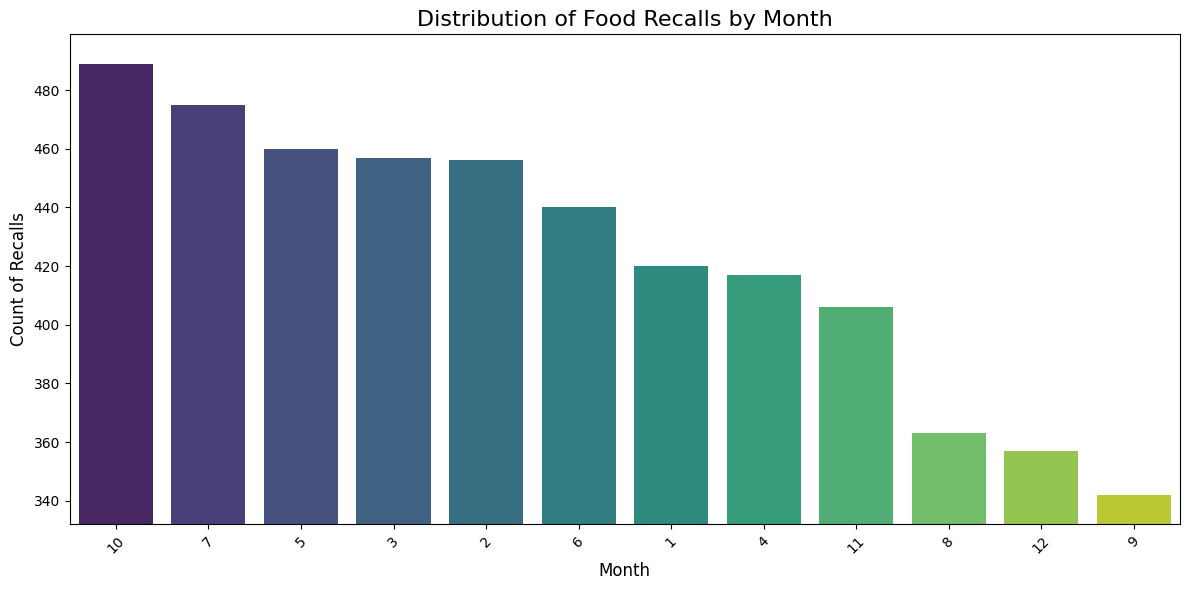

/var/folders/7m/tn2lww617kl3zw0vkb4p06q80000gp/T/ipykernel_50476/1431482563.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_data, x='day', order=train_data['day'].value_counts().index, palette='plasma')


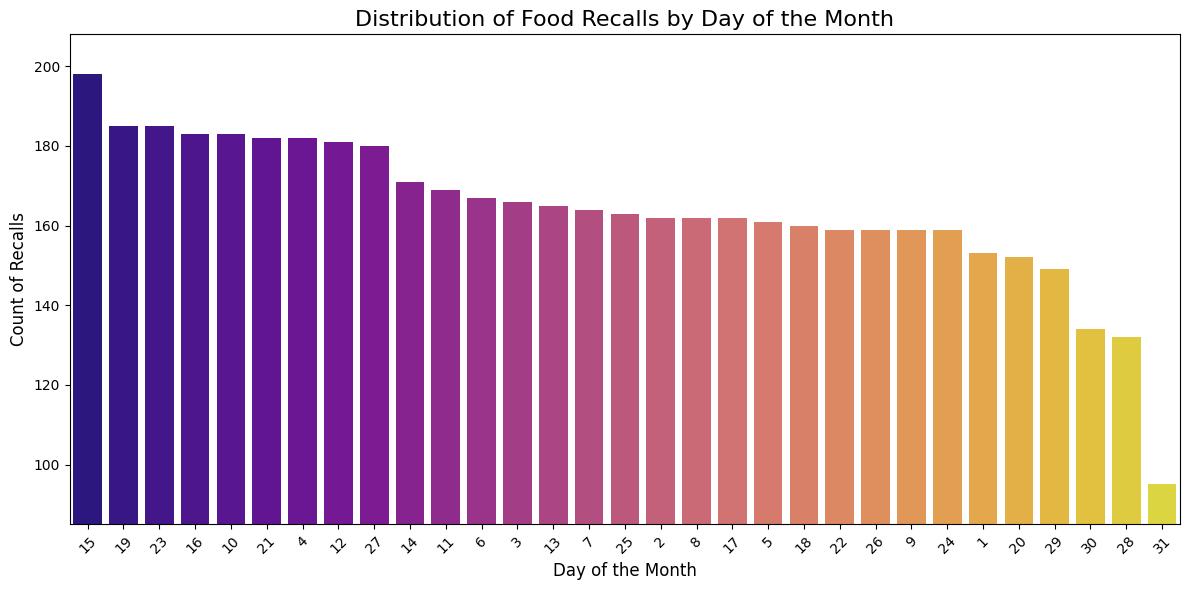

In [8]:
# Plotting the distribution of recalls by month
plt.figure(figsize=(12, 6))
sns.countplot(data=train_data, x='month', order=train_data['month'].value_counts().index, palette='viridis')
plt.title('Distribution of Food Recalls by Month', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Count of Recalls', fontsize=12)
plt.ylim(train_data['month'].value_counts().min() - 10, train_data['month'].value_counts().max() + 10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotting the distribution of recalls by day of the month
plt.figure(figsize=(12, 6))
sns.countplot(data=train_data, x='day', order=train_data['day'].value_counts().index, palette='plasma')
plt.title('Distribution of Food Recalls by Day of the Month', fontsize=16)
plt.xlabel('Day of the Month', fontsize=12)
plt.ylabel('Count of Recalls', fontsize=12)
plt.ylim(train_data['day'].value_counts().min() - 10, train_data['day'].value_counts().max() + 10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Month Distribution Analysis

The distribution of food recalls by **month** shows that the months with the highest number of recalls are **October (489)**, **July (475)**, and **May (460)**. These months are relatively close in terms of recall counts, which suggests that food safety incidents might be more frequent during these months. The months with fewer recalls are typically **September (342)** and **December (357)**, with slightly lower counts compared to other months. 

Interestingly, this distribution does not show a significant seasonal variation, indicating that food safety issues can occur throughout the year.

### Day of the Month Distribution Analysis

The **day of the month** distribution reveals a more evenly spread pattern, with the most common days for food recalls being the **15th (198)**, **19th (185)**, and **23rd (185)**. These days seem to appear more frequently, which could indicate periodic reporting or other operational patterns.

On the other hand, **days 28th (132)** and **31st (95)** have the fewest recalls. This lower number could be due to these days occurring less often in a year (as some months have fewer than 31 days), or they may simply not align with higher recall frequencies.

This distribution suggests that there is no clear pattern for the exact day of the month.

### Title and Text Analysis

#### Why is it interesting to check the **Title** and **Text** columns?

The **Title** and **Text** columns contain crucial information about the food recall incidents. Analyzing these textual features can help us understand the nature of the recalls and provide insights into the risk levels associated with different food products. Here's why it’s interesting to explore these columns:

- **Title Analysis**: The **Title** column typically contains brief summaries or alerts about the food recall incidents. By analyzing the distribution of keywords, phrases, or specific terms in the titles, we can get a quick sense of the types of issues being reported. For instance, certain keywords like “salmonella,” “listeria,” or “plastic fragments” may appear frequently, indicating common hazards or types of contamination in the food supply.
  
- **Text Analysis**: The **Text** column, containing more detailed descriptions, offers a deeper look into the incidents. It can provide essential context such as the specific batch numbers, manufacturers involved, and the precise reasons for the recall. This text may contain additional clues that can be used to detect patterns and nuances in food safety hazards that aren’t immediately apparent from the titles alone.

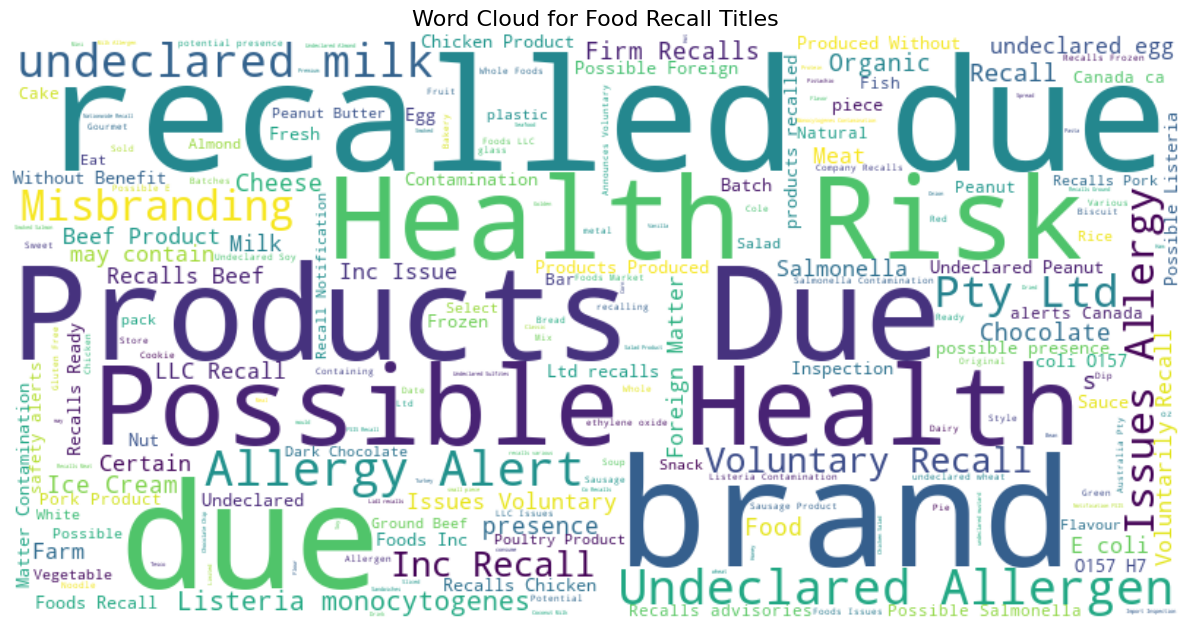

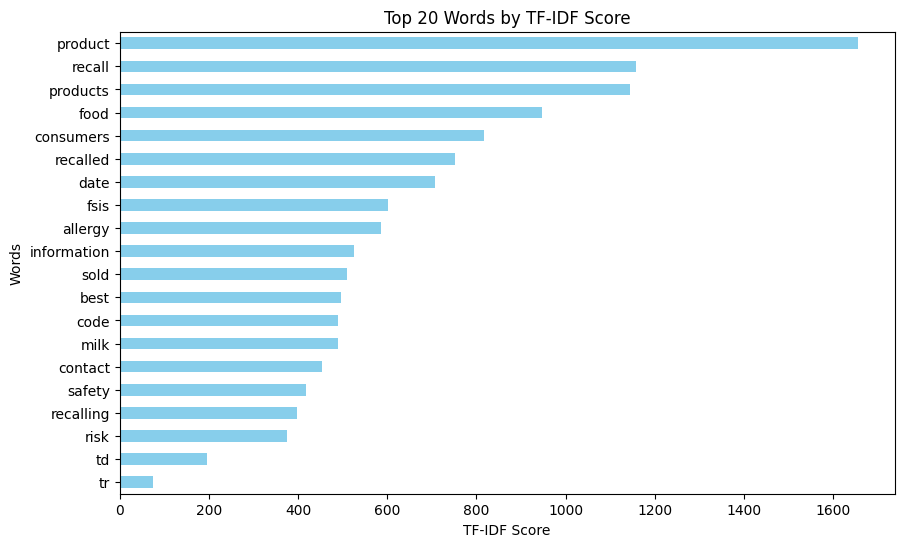

In [10]:
# Combine all titles into a single text string
title_text = ' '.join(train_data['title'].dropna().astype(str))

# Generate the word cloud for titles
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(title_text)

# Plot the word cloud for titles
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Food Recall Titles', fontsize=16)
plt.tight_layout()
plt.show()


# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=20)

# Fit and transform the text data
X = vectorizer.fit_transform(train_data['text'].dropna())

# Display the top 20 most significant words
features = vectorizer.get_feature_names_out()
top_words = pd.DataFrame(X.toarray(), columns=features).sum().sort_values(ascending=False).head(20)

# Plotting the top 20 words based on their TF-IDF scores
plt.figure(figsize=(10, 6))
top_words.plot(kind='barh', color='skyblue')
plt.xlabel('TF-IDF Score')
plt.ylabel('Words')
plt.title('Top 20 Words by TF-IDF Score')
plt.gca().invert_yaxis()  # Invert y-axis to display the highest TF-IDF score at the top
plt.show()


### Conclusions from Title and Text Analysis

From the analysis of the most frequent words (as visualized in the word cloud) and the TF-IDF scores, we can draw several conclusions about the nature of food recalls:

1. **Recall Focus**: Terms like **'recalled'**, **'recall'**, and **'recalled due'** dominate, highlighting that the core of the dataset is food recalls.

2. **Health Risks**: There is significant concern with **'Health Risk'**, **'Allergy Alert'**, and allergens like **'milk'** and **'peanuts'**. This suggests that allergens are a major driver for food recalls.

3. **Regulatory Involvement**: Words such as **'fsis'** (Food Safety and Inspection Service) and **'Inc Recall'** underscore the importance of regulatory bodies in the recall process.

4. **Product-Specific Issues**: Products like **'Ice Cream'** and **'Cheese'** are frequently mentioned, indicating that some food categories (as we saw earlier) are more prone to recalls.

### Overall Implications:
The most frequent and TF-IDF significant words suggest that food recalls are heavily driven by health risks, particularly those associated with allergens and microbial contamination.

In conclusion, understanding the most frequent words and TF-IDF scores provides valuable insight into the underlying causes of food recalls, emphasizing the importance of safety measures, proper labeling, and swift, transparent communication in the food industry.

---
## Benchmark Analysis #1: Basic Machine Learning Models
---

### **Objective**
In this benchmark analysis, we aim to perform **text classification** on reports for food recall to predict different categories. Our goal is to evaluate and compare the performance of a set of **basic machine learning algorithms** and assess how well they can classify food recall information based on both **short titles** and **full text descriptions**. 

We will first focus on predicting the **hazard category** based on the title column, by evaluating the performance with **hyperparameter tuning** and without. Once we identify the best-performing model, we will repeat the process to predict the **hazard category** using the full text description. Finally, we will use the estimator with the best performance to assess the classification task of the **hazard type** by using either the titles or texts.

The same procedure will be repeated for the **product category** at first then we will move to the **product types**.

### **Step 1: Classify by Hazard Category (Using Titles)**

- **Why Hazard Category First?**  
  The **hazard category** column contains **fewer classes** (10 unique categories) compared to the other columns (e.g., product category with 22 classes, hazard with 128 classes), making it a suitable starting point for our benchmark analysis. The titles themselves are short, which allows us to focus on basic machine learning models and test the limits of text classification.

- **Processing**:  
  - Clean the text data in the **title** and **text** columns by converting all text to lowercase, removing stopwords, and eliminating special characters or punctuation.
  - Use **TF-IDF (Term Frequency-Inverse Document Frequency)** vectorization to convert the title text into numerical features for the models.
  - The dataset will be shuffled to prevent any bias or ordering effects before splitting it into stratified training and testing sets.

- **Modeling**:  
  - We will start with a collection of basic machine learning models for classification, including:
    - Logistic Regression
    - Naive Bayes
    - Support Vector Machines (SVM)
    - Random Forest
    - K-Nearest Neighbors (KNN)
    - Gradient Boosting

- **Training & Evaluation**:  
  - Train the models using the **title** column and predict the **hazard category**.
  - Evaluate model performance by using metrics such as **accuracy**, **precision**, **recall**, and **F1 score**.

- **Hyperparameter Tuning**:  
  - For each model, use **GridSearchCV** to perform hyperparameter tuning to find the best configuration for each algorithm.
  - Compare the performance of the **vanilla models** (models with default parameters) to the **tuned models** (models optimized with GridSearchCV).

- **Performance Comparison**:  
  - We will compare the models' performance based on the evaluation metrics (accuracy and F1 score)

---

### **Step 2: Classify by Hazard Category (Using Full Text)**

- **Why Use the Text Column?**  
  The **text** column provides much more context and information than the **title** column. This richer information is expected to improve the model's performance for hazard category classification. By using the full text, we expect the models to yield better results.


- **Modeling & Evaluation**:  
  - The same set of models (both vanilla and tuned) will be used to classify the **hazard category** based on the **text** column.
  - We will compare the performance of the models trained on the **title** column to those trained on the **text** column. This will help us evaluate how much the additional context in the text impacts the model's accuracy.

---

### **Step 3: Classify by Hazard (Using Titles and Full Text)**

- **Objective**: Finally, we will focus on predicting the **hazard types** from the `hazard` column, which has 128 unique hazard types using the best performing model that was found earlier.

- **Approach**:  
  - As with the previous steps, we will use both the **title** and **text** columns to classify the **hazard**.
  - The models' performance will be evaluated and compared across both columns.

---

### **Step 4: Classify by Product Category (Using Titles and Full Text)**

- **Objective**: We will apply the same process to predict the **product category** from the `product-category` column, which has 22 unique categories and later move on the **product type** from the `product` column.

- **Approach**:  
  - Perform similar steps as above, using both the **title** and **text** columns.
  - Evaluate performance based on accuracy and F1 score.



By the end of this process, we will have performed a detailed benchmark analysis, compared multiple models, and selected the most efficient algorithm for text classification in food hazard prediction.

### Accuracy vs. Macro F1 Score in Multilabel Classification

---

#### **Accuracy** in Multilabel Classification:

- **Definition**: Accuracy in multilabel classification often refers to **Subset Accuracy** or **Exact Match Ratio**. It measures the percentage of samples for which **all labels are correctly predicted**. In other words, it considers a prediction correct only if **all the labels for that sample are predicted correctly**.

  $
  \text{Accuracy} = \frac{\text{Number of samples where all labels are correct}}{\text{Total number of samples}}
  $

- **Pros**: Simple to understand and easy to compute.
- **Cons**: In multilabel problems, where each instance can have multiple correct labels, this metric can be very strict and not particularly informative. For instance, even if the model predicts most labels correctly, it will still be penalized if it misses even one label for a sample. This can make the metric less useful when dealing with multiple labels, especially in imbalanced datasets.

---

#### **Macro F1 Score** in Multilabel Classification:

- **Definition**: The **F1 score** is the harmonic mean of Precision and Recall. In multilabel classification, the **macro F1 score** calculates the F1 score for each label independently, then takes the **average** across all labels, treating each label equally. The macro F1 score balances both false positives and false negatives across all labels.

  $
  \text{Macro F1} = \frac{1}{L} \sum_{i=1}^{L} \text{F1}_i
  $
  where \( L \) is the number of labels, and $ \text{F1}_i $ is the F1 score for the $ i $-th label.

- **Pros**: The macro F1 score gives a better picture of how well the model is performing across **all labels**. It does not allow the performance on one label to dominate the result. It is especially useful when there is **class imbalance**.
- **Cons**: It can be less intuitive than accuracy and requires both precision and recall to be high for all labels to achieve a good F1 score. However, it is generally more informative than accuracy in multilabel settings.

---

#### Which is better for multilabel classification?

- **Macro F1 Score** is generally the **preferred metric** in multilabel classification, especially when:
  1. **Class imbalance** exists: Some labels might be more frequent than others. In this case, accuracy might be misleading because it could be dominated by the more frequent labels. The macro F1 score treats each label equally, regardless of frequency.
  2. **Performance on all labels matters equally**: If we care about the model's performance across all labels (even if some labels are harder to predict than others), the macro F1 score provides a more balanced measure.
  3. **Handling False Positives/Negatives**: The macro F1 score considers both precision and recall, meaning it penalizes both false positives and false negatives. This helps ensure that the model is not just predicting the majority class well but also is balanced in its prediction across the labels.

- **Accuracy** might be used in cases where **exact matches** for all labels are critical, but this is a rare scenario in multilabel classification, and so **macro F1 score** is almost always preferred for general-purpose evaluation.

### Further Processing and cleaning text and title columns

In [7]:
# Define a function to preprocess the text (removing special characters, stopwords, etc.)

def preprocess_text(text):
    text = text.lower()  # Convert text to lowercase
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = ' '.join([word for word in text.split() if word not in ENGLISH_STOP_WORDS])  # Remove stopwords
    return text

# Apply preprocessing to the 'title' and 'text' columns
train_data['clean-title'] = train_data['title'].apply(preprocess_text)
train_data['clean-text'] = train_data['text'].apply(preprocess_text)

# Shuffle the data
train_data=train_data.sample(frac=1).reset_index(drop=True)

### TF-IDF Vectorization

In [8]:
# Let's start by using the "title" column
X = train_data['clean-title']
y = train_data['hazard-category']

# Splitting data into stratified train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Vectorizing the text data using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

### Models and Hyperparameters values

### Hyperparameter Selection Explanation for Grid Search

The following hyperparameter values were chosen based on standard practices and common recommendations for each algorithm. These ranges are designed to balance model complexity, training time, and performance across different types of tasks.

#### 1. **Logistic Regression**
- **C (Regularization strength)**: A logarithmic scale (`0.001` to `100`) is used to cover a wide range of possible regularization strengths, allowing the model to choose between underfitting (high regularization) and overfitting (low regularization).
- **Penalty**: `'l2'` is the most common choice for regularization in Logistic Regression, but `'l1'` may also be tested for sparsity and feature selection.
- **Solver**: The solvers `'lbfgs'` and `'newton-cg'` were selected for their compatibility with different types of regularization and efficiency on smaller vs larger datasets.

#### 2. **Support Vector Machine (SVM)**
- **C (Regularization parameter)**: A logarithmic range (`0.01` to `100`) allows the model to adjust its complexity while balancing overfitting and underfitting.
- **Kernel**: `'linear'`, `'rbf'`, and `'poly'` kernels cover different decision boundary shapes, providing flexibility depending on the data.
- **Gamma**: For non-linear kernels (`rbf` and `poly`), values from `0.001` to `10` explore the model’s sensitivity to the decision boundary’s curvature.

#### 3. **Random Forest**
- **n_estimators**: The range from `100` to `1000` covers a wide spectrum of tree ensemble sizes, which impacts both performance and computation time.
- **max_depth**: From `5` to `30`, this allows models to grow trees without restrictions, while also testing with shallow trees to prevent overfitting.
- **min_samples_split** and **min_samples_leaf**: These parameters control how the trees grow, with higher values reducing overfitting by requiring more samples for splits or leaves.

#### 4. **Gradient Boosting**
- **n_estimators**: A value from `50` to `500` trees allows the model to experiment with different boosting rounds, balancing training time and performance.
- **learning_rate**: Value between `0.001` to `0.3` is tested to manage the trade-off between model complexity and the number of estimators.
- **max_depth**: Shallow trees with depths from `3` to `9` ensure flexibility in capturing complex interactions while avoiding overfitting.

#### 5. **K-Nearest Neighbors (KNN)**
- **n_neighbors**: A range from `3` to `50` neighbors helps to control the trade-off between bias and variance, which is essential for KNN performance.
- **Weights**: `'uniform'` (all neighbors contribute equally) vs `'distance'` (closer neighbors have more influence) is tested for different distance-based patterns in the data.
- **Metric**: The range includes `'minkowski'`, `'euclidean'`, and `'manhattan'`, providing different ways to measure distance between points.

#### 6. **Naive Bayes**
- **alpha (Smoothing parameter)**: A logarithmic scale from `0.001` to `10` ensures that the model can adjust the level of smoothing to prevent zero probabilities.
- **fit_prior**: Testing both `True` and `False` allows the model to either learn class priors or assume they are uniform.

### Why These Ranges?
These hyperparameter ranges cover:
- A wide enough search space to explore different model complexities.
- Commonly accepted ranges that balance computation time and model performance.
- Flexibility for each algorithm to adapt to different dataset characteristics, from simpler tasks to more complex, high-dimensional datasets.

Grid search within these ranges allows fine-tuning of each model to maximize the F1 score, ensuring the best possible performance for the classification task.

In [123]:
# Define a collection of baseline (vanilla) models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Support Vector Machine": SVC(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": MultinomialNB()
}

# Define hyperparameters for grid search (example hyperparameters for some models)
param_grid = {
    "Logistic Regression": {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['lbfgs', 'newton-cg']
    },
    "Support Vector Machine": {
        'C': [0.01, 0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': [0.001, 0.01, 0.1, 1, 10]
    },
    "Random Forest": {
        'n_estimators': [100, 200, 500, 1000],
        'max_depth': [5, 10, 20, 30],
        'min_samples_split': [2],
        'min_samples_leaf': [1, 2]
    },
    "Gradient Boosting": {
        'n_estimators': [100],
        'learning_rate': [0.1],
        'max_depth': [3],
    },
    "KNN": {
        'n_neighbors': [3, 5, 10, 20, 30, 40, 50],
        'weights': ['uniform', 'distance'],
        'metric': ['minkowski', 'euclidean', 'manhattan']
    },
    "Naive Bayes": {
        'alpha': [0.001, 0.01, 0.1, 1, 10],
        'fit_prior': [True, False]
    }
}

### Models training and Hyperparameter tuning

In [124]:
# To store results for comparison
results = []

# Train and evaluate models
for model_name, model in models.items():
    # Vanilla (default) model
    print(f"Training vanilla model: {model_name}")
    model.fit(X_train_tfidf, y_train)
    vanilla_pred = model.predict(X_test_tfidf)
    vanilla_score = model.score(X_test_tfidf, y_test)
    vanilla_report = classification_report(y_test, vanilla_pred, zero_division=1)   #zero_division=1 to assign a value of 1.0 to the metric when no predicted samples exist for a class. This approach might be appropriate to avoid penalizing the model.
    
    # # Calculate Macro F1 score for the vanilla model
    vanilla_f1 = f1_score(y_test, vanilla_pred, average='macro', zero_division=1)
    vanilla_report = classification_report(y_test, vanilla_pred, zero_division=1)
    
    # Perform grid search for hyperparameter tuning if applicable
    if param_grid.get(model_name):
        print(f"Performing grid search for: {model_name}")
        grid_search = GridSearchCV(model, param_grid[model_name], cv=2, n_jobs=-1, verbose=1)
        grid_search.fit(X_train_tfidf, y_train)
        best_model = grid_search.best_estimator_
        tuned_pred = best_model.predict(X_test_tfidf)
        tuned_f1 = f1_score(y_test, tuned_pred, average='macro', zero_division=1)
        tuned_score = best_model.score(X_test_tfidf, y_test)
        tuned_report = classification_report(y_test, tuned_pred, zero_division=1)
        
        # Add results for comparison
        results.append({
            "Model": model_name,
            "Vanilla Accuracy": vanilla_score,
            "Tuned Accuracy": tuned_score,
            "Vanilla Macro F1": vanilla_f1,
            "Tuned Macro F1": tuned_f1,
            "Vanilla Report": vanilla_report,
            "Tuned Report": tuned_report,
            "Best Params": grid_search.best_params_
        })
    else:
        # For models without hyperparameters to tune
        results.append({
            "Model": model_name,
            "Vanilla Accuracy": vanilla_score,
            "Tuned Accuracy": vanilla_score,
            "Vanilla Macro F1": vanilla_f1,
            "Tuned Macro F1": vanilla_f1,  # Same if no tuning
            "Vanilla Report": vanilla_report,
            "Tuned Report": vanilla_report,
            "Best Params": "N/A"
        })

Training vanilla model: Logistic Regression
Performing grid search for: Logistic Regression
Fitting 2 folds for each of 24 candidates, totalling 48 fits


/opt/anaconda3/envs/Omni/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
24 fits failed out of a total of 48.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/Omni/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/Omni/lib/python3.11/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/Omni/lib/python3.11/site-packages/sklearn/linear_model/_lo

Training vanilla model: Support Vector Machine
Performing grid search for: Support Vector Machine
Fitting 2 folds for each of 75 candidates, totalling 150 fits
Training vanilla model: Random Forest
Performing grid search for: Random Forest
Fitting 2 folds for each of 32 candidates, totalling 64 fits


/opt/anaconda3/envs/Omni/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Training vanilla model: Gradient Boosting
Performing grid search for: Gradient Boosting
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Training vanilla model: KNN
Performing grid search for: KNN
Fitting 2 folds for each of 42 candidates, totalling 84 fits


/opt/anaconda3/envs/Omni/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/anaconda3/envs/Omni/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/Omni/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/Omni/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/Omni/lib

Training vanilla model: Naive Bayes
Performing grid search for: Naive Bayes
Fitting 2 folds for each of 10 candidates, totalling 20 fits


In [126]:
# Convert results to DataFrame for comparison
accuracy_and_parameters_columns = [{'Model':model_details['Model'], 'Vanilla Accuracy':model_details['Vanilla Accuracy'], 'Tuned Accuracy':model_details['Tuned Accuracy'], 'Vanilla Macro F1':model_details['Vanilla Macro F1'], 'Tuned Macro F1':model_details['Tuned Macro F1'], 'Best Params':model_details['Best Params']} for model_details in results]
results_df = pd.DataFrame(accuracy_and_parameters_columns)
results_df

,Model,Vanilla Accuracy,Tuned Accuracy,Vanilla Macro F1,Tuned Macro F1,Best Params
0,Logistic Regression,0.802360,0.834808,0.399357,0.684584,"{'C': 100, 'penalty': 'l2', 'solver': 'newton-..."
1,Support Vector Machine,0.802360,0.831858,0.449068,0.679269,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}"
2,Random Forest,0.820059,0.754179,0.622795,0.365378,"{'max_depth': 30, 'min_samples_leaf': 1, 'min_..."
3,Gradient Boosting,0.803343,0.809243,0.642433,0.661100,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
4,KNN,0.738446,0.761062,0.446052,0.464110,"{'metric': 'minkowski', 'n_neighbors': 20, 'we..."
5,Naive Bayes,0.744346,0.805310,0.303086,0.458557,"{'alpha': 0.1, 'fit_prior': True}"


### Model Comparison and Results Summary

After training and tuning a collection of basic machine learning algorithms for text classification on hazard categories, here are the key findings:

- **Improvements**: Models showed improvements after tuning.
- **Best Model**: **Tuned Logistic Regression** performed the best with a **F1 score** of **0.68**.
- **Performance Drop**: **Random Forest** showed a significant performance drop after tuning, with F1 score decreasing from its vanilla model.

### Classification Report of the best model

In [129]:
print(results[0]['Tuned Report'])

                                precision    recall  f1-score   support

                     allergens       0.85      0.93      0.89       371
                    biological       0.85      0.92      0.89       348
                      chemical       0.80      0.61      0.69        57
food additives and flavourings       1.00      0.20      0.33         5
                foreign bodies       0.79      0.74      0.76       112
                         fraud       0.72      0.55      0.63        74
                     migration       1.00      1.00      1.00         1
          organoleptic aspects       1.00      0.36      0.53        11
                  other hazard       0.84      0.59      0.70        27
              packaging defect       1.00      0.27      0.43        11

                      accuracy                           0.83      1017
                     macro avg       0.88      0.62      0.68      1017
                  weighted avg       0.83      0.83      0.83 

#### The same process will be repeated for the text column in a more streamlined way

In [ ]:
def run_benchmark_for_basic_ml_algorithms(x_column, y_column):

    X = train_data[x_column]
    y = train_data[y_column]

    # Splitting data into train and test sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Vectorizing the text data using TF-IDF
    vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    # To store results for comparison
    results = []

    # Train and evaluate models
    for model_name, model in models.items():
        # Vanilla (default) model
        print(f"Training vanilla model: {model_name}")
        model.fit(X_train_tfidf, y_train)
        vanilla_pred = model.predict(X_test_tfidf)
        vanilla_score = model.score(X_test_tfidf, y_test)
        vanilla_report = classification_report(y_test, vanilla_pred, zero_division=1)   # zero_division=1 to assign a value of 1.0 to the metric when no predicted samples exist for a class. This approach is appropriate to avoid penalizing the model.
        
        # # Calculate Macro F1 score for the vanilla model
        vanilla_f1 = f1_score(y_test, vanilla_pred, average='macro', zero_division=1)
        vanilla_report = classification_report(y_test, vanilla_pred, zero_division=1)
        
        # Perform grid search for hyperparameter tuning if applicable
        if param_grid.get(model_name):
            print(f"Performing grid search for: {model_name}")
            grid_search = GridSearchCV(model, param_grid[model_name], cv=2, n_jobs=-1, verbose=1)   # cv=2: The least populated class in y has only 2 members
            grid_search.fit(X_train_tfidf, y_train)
            best_model = grid_search.best_estimator_
            tuned_pred = best_model.predict(X_test_tfidf)
            tuned_f1 = f1_score(y_test, tuned_pred, average='macro', zero_division=1)
            tuned_score = best_model.score(X_test_tfidf, y_test)
            tuned_report = classification_report(y_test, tuned_pred, zero_division=1)
            
            # Add results for comparison
            results.append({
                "Model": model_name,
                "Vanilla Accuracy": vanilla_score,
                "Tuned Accuracy": tuned_score,
                "Vanilla Macro F1": vanilla_f1,
                "Tuned Macro F1": tuned_f1,
                "Vanilla Report": vanilla_report,
                "Tuned Report": tuned_report,
                "Best Params": grid_search.best_params_
            })
        else:
            # For models without hyperparameters to tune
            results.append({
                "Model": model_name,
                "Vanilla Accuracy": vanilla_score,
                "Tuned Accuracy": vanilla_score,
                "Vanilla Macro F1": vanilla_f1,
                "Tuned Macro F1": vanilla_f1,  # Same if no tuning
                "Vanilla Report": vanilla_report,
                "Tuned Report": vanilla_report,
                "Best Params": "N/A"
            })

    
    return results

In [ ]:
def show_results(results):
    accuracy_and_parameters_columns = [{'Model':model_details['Model'], 'Vanilla Accuracy':model_details['Vanilla Accuracy'], 'Tuned Accuracy':model_details['Tuned Accuracy'], 'Vanilla Macro F1':model_details['Vanilla Macro F1'], 'Tuned Macro F1':model_details['Tuned Macro F1'], 'Best Params':model_details['Best Params']} for model_details in results]
    return pd.DataFrame(accuracy_and_parameters_columns)

In [ ]:
results = run_benchmark_for_basic_ml_algorithms(x_column= 'clean-text', y_column= 'hazard-category' )
show_results(results)

Training vanilla model: Logistic Regression
Performing grid search for: Logistic Regression
Fitting 2 folds for each of 24 candidates, totalling 48 fits


/opt/anaconda3/envs/Omni/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
24 fits failed out of a total of 48.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/Omni/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/Omni/lib/python3.11/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/Omni/lib/python3.11/site-packages/sklearn/linear_model/_lo

Training vanilla model: Support Vector Machine
Performing grid search for: Support Vector Machine
Fitting 2 folds for each of 75 candidates, totalling 150 fits
Training vanilla model: Random Forest
Performing grid search for: Random Forest
Fitting 2 folds for each of 32 candidates, totalling 64 fits
Training vanilla model: Gradient Boosting
Performing grid search for: Gradient Boosting
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Training vanilla model: KNN
Performing grid search for: KNN
Fitting 2 folds for each of 42 candidates, totalling 84 fits


/opt/anaconda3/envs/Omni/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/Omni/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/Omni/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/Omni/lib/python3.11/site-packages/sklearn/base.py", line 764, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/Omni/lib/python3.11/site-packages/sklearn/neighbors

Training vanilla model: Naive Bayes
Performing grid search for: Naive Bayes
Fitting 2 folds for each of 10 candidates, totalling 20 fits
                    Model  Vanilla Accuracy  Tuned Accuracy  Vanilla Macro F1  \
0     Logistic Regression          0.869223        0.901672          0.477980   
1  Support Vector Machine          0.869223        0.899705          0.490660   
2           Random Forest          0.882989        0.886922          0.507935   
3       Gradient Boosting          0.890855        0.891839          0.631718   
4                     KNN          0.777778        0.802360          0.463138   
5             Naive Bayes          0.763029        0.802360          0.307618   

   Tuned Macro F1                                        Best Params  
0        0.636746  {'C': 100, 'penalty': 'l2', 'solver': 'newton-...  
1        0.603322           {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}  
2        0.491575  {'max_depth': 30, 'min_samples_leaf': 1, 'min_...  
3        0.

,Model,Vanilla Accuracy,Tuned Accuracy,Vanilla Macro F1,Tuned Macro F1,Best Params
0,Logistic Regression,0.869223,0.901672,0.477980,0.636746,"{'C': 100, 'penalty': 'l2', 'solver': 'newton-..."
1,Support Vector Machine,0.869223,0.899705,0.490660,0.603322,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}"
2,Random Forest,0.882989,0.886922,0.507935,0.491575,"{'max_depth': 30, 'min_samples_leaf': 1, 'min_..."
3,Gradient Boosting,0.890855,0.891839,0.631718,0.568349,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
4,KNN,0.777778,0.802360,0.463138,0.490568,"{'metric': 'minkowski', 'n_neighbors': 10, 'we..."
5,Naive Bayes,0.763029,0.802360,0.307618,0.610138,"{'alpha': 0.001, 'fit_prior': True}"


### Summary

- **Best Performance**: **Tuned Logistic Regression** performed best (again).
- **Tuning Effectiveness**: Tuning improved performance for **Logistic Regression**, **SVM**, and **Naive Bayes**, but led to a decrease in accuracy for **Random Forest** and **Gradient Boosting** after tuning.
- **Key Takeaway**: Hyperparameter tuning generally improves models like Logistic Regression and Naive Bayes, but may not always be beneficial for all algorithms.


In [133]:
print(results[0]['Tuned Report'])

                                precision    recall  f1-score   support

                     allergens       0.92      0.96      0.94       371
                    biological       0.93      0.98      0.96       348
                      chemical       0.82      0.72      0.77        57
food additives and flavourings       1.00      0.20      0.33         5
                foreign bodies       0.92      0.96      0.94       112
                         fraud       0.70      0.61      0.65        74
                     migration       1.00      0.00      0.00         1
          organoleptic aspects       0.57      0.36      0.44        11
                  other hazard       0.71      0.56      0.62        27
              packaging defect       1.00      0.55      0.71        11

                      accuracy                           0.90      1017
                     macro avg       0.86      0.59      0.64      1017
                  weighted avg       0.90      0.90      0.90 

### Model Selection for Hazard Type Prediction

Based on the performance of the models during the benchmark analysis, we will proceed with the following model for hazard type prediction:

- **Logistic Regression**: We will use the **Tuned Logistic Regression** model to predict the hazard type when using the titles as features. This model performed well when applied to the title column and in the text column as well.

These choices are based on the models performance during the benchmark process, and we believe they will yield reliable results for hazard type prediction.

### **Reminder**

When handling a **multi-label classification** task with a larger and different set of classes from before, it is often appropriate to continue using the **best-performing algorithm** from previous experiments for the following reasons:

- **Algorithm Robustness**: The best-performing model likely has strengths in distinguishing multiple labels, making it suitable for expanding to a larger number of classes.
  
- **Consistency in Data**: Since the training data remains the same, the relationships between features and labels are likely to follow similar patterns, meaning the chosen algorithm can generalize well to new labels.
  
- **Hyperparameter Optimization**: Previous hyperparameter tuning has already been optimized for the task, saving time and ensuring the algorithm's configuration is still relevant for the new set of classes.

- **Performance Continuity**: A model that performed well previously is likely to retain its ability to generalize to new classes, especially when the classes share similar characteristics or domain.

In [134]:
def run_Logistic_Regression_Tuned(x_column, y_column):

    X = train_data[x_column]
    y = train_data[y_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   # Non stratified splitting 

    vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)


    model = LogisticRegression(max_iter=1000, C=100, penalty='l2', solver='newton-cg')
    model.fit(X_train_tfidf, y_train)
    predictions = model.predict(X_test_tfidf)
    Classification_report = classification_report(y_test, predictions, zero_division=1)
        
    print(Classification_report)

In [135]:
run_Logistic_Regression_Tuned(x_column='clean-title', y_column='hazard')


                                                   precision    recall  f1-score   support

                                        Aflatoxin       0.00      0.00      0.00         1
                                   abnormal smell       1.00      0.00      0.00         1
                                        allergens       1.00      0.00      0.00         1
                                           almond       0.75      0.53      0.62        17
             altered organoleptic characteristics       1.00      0.00      0.00         1
                                        amygdalin       1.00      1.00      1.00         1
                           antibiotics, vet drugs       1.00      0.00      0.00         1
                                    bacillus spp.       1.00      0.25      0.40         4
                                    bone fragment       1.00      0.00      0.00         1
                                       brazil nut       1.00      0.00      0.00         

In [139]:
run_Logistic_Regression_Tuned(x_column='clean-text', y_column='hazard')

                                                   precision    recall  f1-score   support

                                        Aflatoxin       1.00      1.00      1.00         1
                                   abnormal smell       1.00      0.00      0.00         1
                                  alcohol content       0.00      1.00      0.00         0
                                        allergens       1.00      0.00      0.00         1
                                           almond       0.85      0.65      0.73        17
             altered organoleptic characteristics       1.00      0.00      0.00         1
                                        amygdalin       1.00      1.00      1.00         1
                           antibiotics, vet drugs       1.00      0.00      0.00         1
                                    bacillus spp.       1.00      0.50      0.67         4
                                    bone fragment       1.00      0.00      0.00         

### Now on to the Product Category and Product Classification

In [157]:
results = run_benchmark_for_basic_ml_algorithms(x_column= 'clean-title', y_column= 'product-category' )

Training vanilla model: Logistic Regression
Performing grid search for: Logistic Regression
Fitting 2 folds for each of 24 candidates, totalling 48 fits
Training vanilla model: Support Vector Machine
Performing grid search for: Support Vector Machine
Fitting 2 folds for each of 75 candidates, totalling 150 fits
Training vanilla model: Random Forest
Performing grid search for: Random Forest
Fitting 2 folds for each of 32 candidates, totalling 64 fits
Training vanilla model: Gradient Boosting
Performing grid search for: Gradient Boosting
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Training vanilla model: KNN
Performing grid search for: KNN
Fitting 2 folds for each of 42 candidates, totalling 84 fits


/opt/anaconda3/envs/Omni/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/Omni/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/Omni/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/Omni/lib/python3.11/site-packages/sklearn/base.py", line 764, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/Omni/lib/python3.11/site-packages/sklearn/neighbors

Training vanilla model: Naive Bayes
Performing grid search for: Naive Bayes
Fitting 2 folds for each of 10 candidates, totalling 20 fits
                    Model  Vanilla Accuracy  Tuned Accuracy  Vanilla Macro F1  \
0     Logistic Regression          0.659784        0.722714          0.357807   
1  Support Vector Machine          0.659784        0.726647          0.390429   
2           Random Forest          0.645034        0.542773          0.488226   
3       Gradient Boosting          0.699115        0.683382          0.607649   
4                     KNN          0.595870        0.651917          0.379367   
5             Naive Bayes          0.483776        0.653884          0.152572   

   Tuned Macro F1                                        Best Params  
0        0.623356  {'C': 100, 'penalty': 'l2', 'solver': 'newton-...  
1        0.625222         {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}  
2        0.272074  {'max_depth': 30, 'min_samples_leaf': 1, 'min_...  
3        0.

In [ ]:
show_results(results)

,Model,Vanilla Accuracy,Tuned Accuracy,Vanilla Macro F1,Tuned Macro F1,Best Params
0,Logistic Regression,0.659784,0.722714,0.357807,0.623356,"{'C': 100, 'penalty': 'l2', 'solver': 'newton-..."
1,Support Vector Machine,0.659784,0.726647,0.390429,0.625222,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}"
2,Random Forest,0.640118,0.547689,0.497557,0.272432,"{'max_depth': 30, 'min_samples_leaf': 1, 'min_..."
3,Gradient Boosting,0.685349,0.687316,0.585459,0.590882,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
4,KNN,0.595870,0.651917,0.379367,0.562808,"{'metric': 'minkowski', 'n_neighbors': 10, 'we..."
5,Naive Bayes,0.483776,0.653884,0.152572,0.563077,"{'alpha': 0.01, 'fit_prior': True}"


In [160]:
print(results[0]['Tuned Report'])

                                                   precision    recall  f1-score   support

                              alcoholic beverages       1.00      0.42      0.59        12
                      cereals and bakery products       0.73      0.77      0.75       134
     cocoa and cocoa preparations, coffee and tea       0.77      0.79      0.78        42
                                    confectionery       0.78      0.53      0.63        34
dietetic foods, food supplements, fortified foods       0.85      0.65      0.74        26
                                    fats and oils       0.57      1.00      0.73         4
                                   feed materials       1.00      0.00      0.00         1
                   food additives and flavourings       1.00      0.00      0.00         2
                           food contact materials       1.00      1.00      1.00         1
                            fruits and vegetables       0.65      0.70      0.67       10

In [161]:
results = run_benchmark_for_basic_ml_algorithms(x_column= 'clean-text', y_column= 'product-category')

Training vanilla model: Logistic Regression
Performing grid search for: Logistic Regression
Fitting 2 folds for each of 24 candidates, totalling 48 fits
Training vanilla model: Support Vector Machine
Performing grid search for: Support Vector Machine
Fitting 2 folds for each of 75 candidates, totalling 150 fits
Training vanilla model: Random Forest
Performing grid search for: Random Forest
Fitting 2 folds for each of 32 candidates, totalling 64 fits
Training vanilla model: Gradient Boosting
Performing grid search for: Gradient Boosting
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Training vanilla model: KNN
Performing grid search for: KNN
Fitting 2 folds for each of 42 candidates, totalling 84 fits


/opt/anaconda3/envs/Omni/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/Omni/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/Omni/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/Omni/lib/python3.11/site-packages/sklearn/base.py", line 764, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/Omni/lib/python3.11/site-packages/sklearn/neighbors

Training vanilla model: Naive Bayes
Performing grid search for: Naive Bayes
Fitting 2 folds for each of 10 candidates, totalling 20 fits
                    Model  Vanilla Accuracy  Tuned Accuracy  Vanilla Macro F1  \
0     Logistic Regression          0.639135        0.709931          0.355420   
1  Support Vector Machine          0.618486        0.703048          0.378320   
2           Random Forest          0.602753        0.581121          0.447457   
3       Gradient Boosting          0.672566        0.667650          0.493145   
4                     KNN          0.535890        0.570305          0.391512   
5             Naive Bayes          0.483776        0.621436          0.153788   

   Tuned Macro F1                                        Best Params  
0        0.571891     {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}  
1        0.562855         {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}  
2        0.363499  {'max_depth': 30, 'min_samples_leaf': 1, 'min_...  
3        0.

In [150]:
show_results(results)

,Model,Vanilla Accuracy,Tuned Accuracy,Vanilla Macro F1,Tuned Macro F1,Best Params
0,Logistic Regression,0.639135,0.709931,0.355420,0.571891,"{'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}"
1,Support Vector Machine,0.618486,0.703048,0.378320,0.562855,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}"
2,Random Forest,0.589971,0.581121,0.402549,0.366552,"{'max_depth': 30, 'min_samples_leaf': 1, 'min_..."
3,Gradient Boosting,0.669617,0.672566,0.490680,0.498566,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
4,KNN,0.535890,0.570305,0.391512,0.517543,"{'metric': 'minkowski', 'n_neighbors': 5, 'wei..."
5,Naive Bayes,0.483776,0.621436,0.153788,0.556662,"{'alpha': 0.001, 'fit_prior': True}"


In [163]:
print(results[0]['Tuned Report'])

                                                   precision    recall  f1-score   support

                              alcoholic beverages       1.00      0.75      0.86        12
                      cereals and bakery products       0.62      0.76      0.68       134
     cocoa and cocoa preparations, coffee and tea       0.62      0.60      0.61        42
                                    confectionery       0.56      0.53      0.55        34
dietetic foods, food supplements, fortified foods       0.79      0.58      0.67        26
                                    fats and oils       0.80      1.00      0.89         4
                                   feed materials       1.00      0.00      0.00         1
                   food additives and flavourings       1.00      0.00      0.00         2
                           food contact materials       1.00      0.00      0.00         1
                            fruits and vegetables       0.68      0.65      0.67       10

### Model Selection for Product Type Prediction

For predicting the product types, we will use **Tuned Logistic Regression**, as it showed the best overall performance in comparison with other algorithms. Although **Support Vector Machine (SVM)** had a nearly identical F1 score when predicting the product category using the title column, Logistic Regression demonstrated a slight edge in terms of consistency. Therefore, we will proceed with Logistic Regression for predicting the product categories.


In [151]:
run_Logistic_Regression_Tuned(x_column='clean-title', y_column='product')

                                                         precision    recall  f1-score   support

                                 Catfishes (freshwater)       1.00      0.33      0.50         3
                                  Fishes not identified       0.42      0.56      0.48         9
                               Not classified pork meat       0.00      0.00      0.00         1
                    Precooked cooked pork meat products       0.00      0.00      0.00         1
                                          Veggie Burger       1.00      0.00      0.00         3
                                    alcoholic beverages       0.00      1.00      0.00         0
                                        alfalfa sprouts       1.00      0.50      0.67         2
                                                  algae       0.00      0.00      0.00         1
                                  all purpose seasoning       1.00      0.00      0.00         1
                             

In [152]:
run_Logistic_Regression_Tuned(x_column='clean-text', y_column='product')

                                                         precision    recall  f1-score   support

                                 Catfishes (freshwater)       0.75      1.00      0.86         3
                                  Fishes not identified       0.56      0.56      0.56         9
                               Not classified pork meat       0.00      0.00      0.00         1
                    Precooked cooked pork meat products       0.00      0.00      0.00         1
                                          Veggie Burger       1.00      0.33      0.50         3
                                        alfalfa sprouts       1.00      0.50      0.67         2
                                                  algae       1.00      0.00      0.00         1
                                  all purpose seasoning       1.00      1.00      1.00         1
                                            almond milk       0.00      1.00      0.00         0
                             

### Conclusion

After evaluating multiple machine learning algorithms for the classification task, **Logistic Regression** emerged as the best performer, achieving the highest possible **F1 score**. This result highlights its efficiency and effectiveness in handling the problem at hand.

Moreover Logistic Regression remains a lightweight model, making it a favorable choice for scenarios where computational efficiency is crucial and will be considered as an admirable competitor against the the advanced machine learning model that we will test in the next **Benchmark Analysis**.

---
## Benchmark Analysis #2: Transformer Models (XLM-RoBERTa)
---

In this second benchmark analysis, we will explore the use of **advanced machine learning algorithms**, specifically transformer models, to predict the hazard and product categories and types. After completing Benchmark Analysis #1 with basic machine learning algorithms, we aim to see if **transformer-based models**, specifically [**XLM-RoBERTa**](https://huggingface.co/FacebookAI/xlm-roberta-base) from Facebook, can achieve similar or better performance.

The approach will be as follows:

1. **Establishing a Baseline**: We will first train the XLM-RoBERTa transformer model on the **title column** and the **text column** to find out which column of data predicts the **hazard-category** better. These will serve as our baseline models, where we will not focus on extensive hyperparameter tuning to start with.
  
2. **Using the Right Column**: After the training process of the XLM-RoBERTa model on both columns, the baseline scores should provide us with insights into whether the more or less extensive text data enables the model to make better predictions for the **hazard-category**.

3. **Hyperparameter Tuning**: We will experiment with hyperparameter tuning in order to improve the performance of the model and observe if we can achieve better accuracy with the right column of data.

4. **Repeating the Process**: Once we have fine-tuned the model for hazard category and type prediction, we will repeat the same process for **product category prediction** and **product type prediction**, by testing again the title and text columns as features.

5. **Final Model Selection**: At the end of the same process for the product category and product type, we will compare the results from the basic ML models (from Benchmark Analysis #1) and the transformer models (XLM-RoBERTa) to determine the best models for predicting **hazard** and **product categories**, and then **hazard** and **product types**. The final results will distinguish the appropriate model to produce predictions on the **validation dataset from Codalab**.

With this, we will complete the **2nd Assignment on Practical Data Science**, ensuring we have a robust understanding on both traditional and advanced ML models for text classification tasks.

### Preprocessing for Multi-Label Classification with XLM-RoBERTa

XLM-RoBERTa is a powerful transformer model that has been pre-trained on large corpora of online text, learning complex patterns and linguistic structures. It is designed to handle a wide variety of text formats and languages without needing extensive preprocessing. Here’s why minimal preprocessing is important:

- **Preserving Linguistic Information**: Removing punctuation, stopwords, or changing the case of the text may strip away valuable contextual cues that the model relies on for accurate predictions.

- **Transformer Models Handle Raw Text**: Models like XLM-RoBERTa are trained to process raw, unaltered text, so simplifying the input too much can reduce performance.

- **Efficient Tokenization**: XLM-RoBERTa uses its own tokenizer to split text into meaningful units (tokens). Preprocessing can interfere with this process, leading to potential loss of information.

By not applying text preprocessing, we allow the transformer model to leverage its learned knowledge of language structure, leading to better performance.

### Model Training with XLM-RoBERTa: A Clean and Efficient Pipeline

The following function for training an XLM-RoBERTa model follows a neat and tidy end-to-end pipeline that simplifies the process of training, evaluation, and hyperparameter tuning. 

- **End-to-End Workflow**: The pipeline encompasses all stages, from data loading, tokenization, model fine-tuning, to evaluation, making it highly convenient and easy to implement.
- **Easy Hyperparameter Tuning**: The modular structure of the pipeline allows for easy experimentation with hyperparameters (such as learning rate, batch size, and number of epochs) without disrupting the workflow.
- **Streamlined Results**: The function also saves and outputs results in a clear format, allowing us to quickly assess model performance.

This structured approach makes working with XLM-RoBERTa efficient and accessible, even for the complex multi-label classification tasks.

In [ ]:
def train_xlm_roberta(version ,x_column, y_column, stratify=True, learning_rate=1e-5, num_train_epochs=1, weight_decay=0.01, per_device_train_batch_size=5, per_device_eval_batch_size=5):

  # Disable W&B logging
  os.environ["WANDB_MODE"] = "disabled"

  # Load training data from a CSV file
  train = pd.read_csv("/content/incidents_train.csv")   # Google Colab working directory path

  # Select the input text and labels columns from the dataset
  train['input_text'] = train[x_column]
  train['label'] = train[y_column]

  # Encode the target labels
  label_encoder = LabelEncoder()
  train['label'] = label_encoder.fit_transform(train[y_column])

  # Create label2id and id2label mappings for model compatibility
  label2id = {label: idx for idx, label in enumerate(label_encoder.classes_)}
  id2label = {idx: label for label, idx in label2id.items()}

  # Train-test split using stratification (to maintain class distribution)
  if stratify:
    train_df, test_df = train_test_split(train[['input_text', 'label']], test_size=0.2, random_state=42, stratify=train['label'])

  # Traditional train-test split without stratification
  else:
    train_df, test_df = train_test_split(train[['input_text', 'label']], test_size=0.2, random_state=42)

  # Convert pandas dataframes to Hugging Face's Dataset format for efficient processing
  train_dataset = Dataset.from_pandas(train_df)
  test_dataset = Dataset.from_pandas(test_df)

  # Load the RoBERTa tokenizer
  tokenizer = AutoTokenizer.from_pretrained("FacebookAI/xlm-roberta-base")

  # Define a tokenization function
  def tokenize_function(example):
      return tokenizer(example['input_text'], truncation=True)

  # Tokenize the datasets
  train_dataset = train_dataset.map(tokenize_function, batched=True)
  test_dataset = test_dataset.map(tokenize_function, batched=True)

  # Set up a data collator to pad inputs dynamically to the maximum length
  data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

  # Load XLM-RoBERTa model for sequence classification with the correct number of output labels
  num_labels = len(label_encoder.classes_)

  model = AutoModelForSequenceClassification.from_pretrained(
      "FacebookAI/xlm-roberta-base",
      num_labels=num_labels,
      id2label=id2label,
      label2id=label2id
  )

  # Check if GPU is available and assign the device accordingly (CUDA for GPU, CPU otherwise)
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print("Model loaded on: ", device)

  model.to(device)


  # Load the F1 metric and specify macro averaging
  f1_metric = evaluate.load("f1")

  # Define the compute_metrics function to maximize F1 macro average
  def compute_metrics(eval_pred):
      logits, labels = eval_pred
      predictions = np.argmax(logits, axis=-1)

      # Compute the F1 macro average
      f1 = f1_metric.compute(predictions=predictions, references=labels, average="macro")
      return {"f1": f1["f1"]}

  # Set up the training arguments with key hyperparameters for optimization
  training_args = TrainingArguments(
      output_dir="/results",
      evaluation_strategy="epoch",
      save_strategy="epoch",
      learning_rate=learning_rate,
      per_device_train_batch_size=per_device_train_batch_size,
      per_device_eval_batch_size=per_device_eval_batch_size,
      num_train_epochs=num_train_epochs,
      weight_decay=weight_decay,
      load_best_model_at_end=True,
  )

  # Initialize the Trainer with the model, training arguments, dataset, and metrics
  trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=train_dataset,
      eval_dataset=test_dataset,
      tokenizer=tokenizer,
      data_collator=data_collator,
      compute_metrics=compute_metrics
  )

  # Train the model
  trainer.train()

  # Evaluate the model
  predictions = trainer.predict(test_dataset)
  preds = predictions.predictions.argmax(-1)

  # Generate a classification report for the model's performance
  clr = classification_report(test_df['label'], preds, zero_division=1)
  print(clr)

  # Save the trained model and tokenizer to a directory for future use
  trainer.save_model(f'/content/{version}')  # Creates a folder for the model
  tokenizer.save_pretrained(f'/content/{version}')

  # Save the classification report to a txt document to be loaded later
  with open(f'/content/{version}/classification_report.txt', 'w') as file:
    file.write(clr)

  # Save the classification report to a csv document
  training_metrics = {'Epoch': 'epoch','Training Loss': 'train_loss', 'Validation Loss': 'eval_loss', 'F1': 'eval_f1'}
  training_data = {key:value for dictionary_of_metrics in trainer.state.log_history for key,value in dictionary_of_metrics.items()}
  training_data = [{metric: training_data[metric_alias] for metric, metric_alias in training_metrics.items()}]
  pd.DataFrame(training_data).to_csv(f'/content/{version}/training_metrics.csv', index=False)

### Model Training on Google Colab

The function `train_xlm_roberta` was implemented on the Google Colab platform, which provides easy access to powerful GPUs. This enables faster training and fine-tuning of the XLM-RoBERTa model on large datasets, significantly reducing the time required for model optimization. By utilizing Google Colab's GPU support, we can efficiently run the computationally intensive tasks of multi-label text classification, without needing dedicated hardware resources.

The notebook is downloaded and saved as `Xlm_roberta.ipynb` in the same directory.

[Click here to go to the Colab notebook](Xlm_roberta.ipynb)

## Final Results


### Benchmark Analysis #1


| Features | Best Algorithm  | Target | Macro F1 Score | 
|-------|---------------------------|-----------------|------|
| Title | Tuned Logistic Regression | Hazard Category | 0.68 |
| Title | Tuned Logistic Regression | Hazard Type | 0.37 |
| Title | Tuned Logistic Regression | Product Category | 0.62 |
| Title | Tuned Logistic Regression | Product Type | 0.24 |
| Text | Tuned Logistic Regression | Hazard Category | 0.63 |
| Text | Tuned Logistic Regression | Hazard Type | 0.41 |
| Text | Tuned Logistic Regression | Product Category | 0.57 |
| Text | Tuned Logistic Regression | Product Type | 0.20 |


### Benchmark Analysis #2


| Features | Algorithm  | Tuning | Target | Macro F1 Score | 
|-------|---------------|--|-----------------|--|
| Title | XLM - RoBERTa | Vanilla | Hazard Category | 0.18 |
| Text | XLM - RoBERTa | Vanilla | Hazard Category | 0.26 |
| Text | XLM - RoBERTa | Tuned | Hazard Category | 0.65 |
| Text | XLM - RoBERTa | Tuned | Hazard Type | 0.28 |
| Title | XLM - RoBERTa | Tuned | Hazard Type | 0.13 |
| Title | XLM - RoBERTa | Vanilla | Product Category | 0.03 |
| Text | XLM - RoBERTa | Vanilla | Product Category | 0.02 |
| Title | XLM - RoBERTa | Tuned | Product Category | 0.04 |
| Title | XLM - RoBERTa | Tuned | Product Type | 0.0002 |
| Text | XLM - RoBERTa | Tuned | Product Type | 0.011 |




### Best Candidates for Sub Task 1


| Prediction Category | Best Algorithm Type | Best Algorithm Name | Best Feature | Macro F1 Score | 
|----------|---------------------|---------------------|-------------|----------|
| Hazard category | Basic | Tuned Logistic Regression | Title | 0.68 |
| Product category | Basic | Tuned Logistic Regression | Title | 0.62 |


### Best Candidates for Sub Task 2


| Prediction Category | Best Algorithm Type | Best Algorithm Name | Best Feature | Macro F1 Score | 
|----------|---------------------|---------------------|-------------|----------|
| Hazard type | Basic | Tuned Logistic Regression | Text | 0.41 |
| Product type | Basic | Tuned Logistic Regression | Title | 0.24 |


## Suggestions for Further Study

In this assignment, we trained a variety of machine learning models—ranging from basic models to more advanced ones—in an attempt to determine which model produces the best predictions based on F1 score. However, there are several additional techniques we could explore to potentially improve the overall performance and robustness of our predictions:

### 1. **Ensemble Methods: Majority Voting**
   One approach we could have taken is to combine all the models—regardless of their individual F1 scores—into an ensemble method such as majority voting. The idea behind majority voting is to aggregate predictions from all models and take the prediction that occurs most frequently as the final output.

   - **How it works**: For each data point, each model in the ensemble makes a prediction. The final prediction is then determined by the majority class predicted across all models.
   - **Benefit**: This method can improve the robustness of the predictions, as it leverages the diversity of different models and reduces the risk of overfitting that may occur with a single model.

### 2. **Stacking (Stacked Generalization)**
   Another potential approach is stacking, where the predictions of multiple base models are used as features for a higher-level model (often called a meta-model). This meta-model learns how to best combine the outputs of the base models to improve predictive performance.

   - **How it works**: After training the base models, we train a new model (the meta-model) on the predictions of the base models, which serves as a more informed final prediction. Common meta-models include the ones we have already used like logistic regression, random forests, or gradient boosting.
   - **Benefit**: Stacking can leverage the strengths of multiple models in a complementary way, potentially yielding a better predictive performance than any individual base model.
   
### 3. **Bagging (Bootstrap Aggregating)**
   Bagging involves training multiple instances of the same model on different subsets of the training data, generated through bootstrapping (random sampling with replacement). The predictions from each model are then averaged (for regression) or voted on (for classification) to produce a final prediction.

   - **How it works**: By training on different subsets of the data, bagging reduces variance and helps prevent overfitting, especially in models prone to high variance (e.g., decision trees).
   - **Benefit**: This technique can help stabilize predictions and reduce model variance.
   
### 4. **Boosting**
   Boosting involves training a sequence of models where each subsequent model corrects the errors of the previous one. Models are trained in a way that gives more weight to incorrectly predicted instances, improving accuracy over time.

   - **How it works**: Boosting iteratively improves model performance by focusing on harder-to-predict examples. Popular boosting algorithms include AdaBoost, Gradient Boosting, and XGBoost.
   - **Benefit**: Boosting generally leads to highly accurate models and works particularly well when the individual models are weak learners (i.e., models that are just slightly better than random guessing).
   
### 5. **Model Interpretability and Explainability**
   As an additional suggestion, focusing on understanding how each model makes predictions—especially in the context of an ensemble—could provide insights into the strengths and weaknesses of individual models. Techniques like SHAP values or LIME can be used to explain the decisions made by more complex models, which could guide further refinement or adjustments to the ensemble strategy.

   - **How it works**: SHAP (SHapley Additive exPlanations) values and LIME (Local Interpretable Model-agnostic Explanations) are methods that help explain the contribution of each feature to a model's prediction.
   - **Benefit**: Better understanding model decisions can help identify areas of improvement or even inform which models might work best in a combined ensemble.
   
By incorporating these advanced techniques—especially ensemble methods like majority voting, stacking, bagging, or boosting—we may achieve higher predictive performance and more reliable results compared to relying on individual models alone.

---
## Code submission

### Sub Task 1

In [ ]:
validation_df = pd.read_csv(wrk_directory_path + "/Data/unlabeled_validation_data.csv")


for category,column in {'hazard-category':'title', 'product-category':'title'}.items():

    # Preprocess the column
    clean_column = 'clean-' + column
    validation_df[clean_column] = validation_df[column].apply(preprocess_text)

    X_train = train_data[clean_column]

    # Initialize the TfidfVectorizer for text feature extraction
    vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

    # Fit and transform the training data
    X_train_tfidf = vectorizer.fit_transform(X_train)

    y_train = train_data[category]

    # Initialize the Logistic Regression model
    model = LogisticRegression(max_iter=1000, C=100, penalty='l2', solver='newton-cg')

    # Train the model on the entire training data
    model.fit(X_train_tfidf, y_train)

    # Transform the test clean-column using the trained vectorizer
    X_test_tfidf = vectorizer.transform(validation_df[clean_column])

    # Predict the category using the trained model
    validation_df[category] = model.predict(X_test_tfidf)

    # Apply function to create predictions on clean-column
    validation_df[category] = validation_df[clean_column].apply(lambda x: model.predict(vectorizer.transform([x]))[0])

# Show the results
print(validation_df[['hazard-category', 'product-category']])

# Save the results to a CSV if needed
validation_df.to_csv(wrk_directory_path + "/Data/submission.csv.zip", index=False, compression='zip')  # Acceptable submission format: submission.csv.zip specified from Codalab https://codalab.lisn.upsaclay.fr/competitions/19955#phases

    hazard-category                                   product-category
0        biological                       meat, egg and dairy products
1        biological                       meat, egg and dairy products
2        biological                       meat, egg and dairy products
3         allergens                       nuts, nut products and seeds
4    foreign bodies                       meat, egg and dairy products
..              ...                                                ...
560       allergens                              fruits and vegetables
561       allergens  dietetic foods, food supplements, fortified foods
562  foreign bodies                        cereals and bakery products
563       allergens                        cereals and bakery products
564       allergens                                      confectionery

[565 rows x 2 columns]


### Upload Submission 

Upload the compressed submission file before running the next code block because it will overwrite the submission.csv.zip file.

### Sub Task 2

In [ ]:
validation_df = pd.read_csv(wrk_directory_path + "/Data/unlabeled_validation_data.csv")


for category,column in {'hazard':'text', 'product':'title'}.items():

    # Preprocess the column
    clean_column = 'clean-' + column
    validation_df[clean_column] = validation_df[column].apply(preprocess_text)

    X_train = train_data[clean_column]

    # Initialize the TfidfVectorizer for text feature extraction
    vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

    # Fit and transform the training data
    X_train_tfidf = vectorizer.fit_transform(X_train)

    y_train = train_data[category]

    # Initialize the Logistic Regression model
    model = LogisticRegression(max_iter=1000, C=100, penalty='l2', solver='newton-cg')

    # Train the model on the entire training data
    model.fit(X_train_tfidf, y_train)

    # Transform the test clean-column using the trained vectorizer
    X_test_tfidf = vectorizer.transform(validation_df[clean_column])

    # Predict the category using the trained model
    validation_df[category] = model.predict(X_test_tfidf)

    # Apply function to create predictions on clean-column
    validation_df[category] = validation_df[clean_column].apply(lambda x: model.predict(vectorizer.transform([x]))[0])

# Show the results
print(validation_df[['hazard', 'product']])

# Save the results to a CSV if needed
validation_df.to_csv(wrk_directory_path + "/Data/submission.csv.zip", index=False, compression='zip')

                           hazard         product
0          listeria monocytogenes     ground beef
1                escherichia coli     ground beef
2                   enteroviruses     ground beef
3                       pecan nut  sunflower seed
4                  metal fragment     ground beef
..                            ...             ...
560                        cashew          salads
561     milk and products thereof     protein bar
562              plastic fragment         cookies
563  peanuts and products thereof        biscuits
564                        almond         candies

[565 rows x 2 columns]
